# Reconstruction
In this notebook we will review a few "easy-to-implent" Compressed Sensing (CS) reconstruction methods. The goal is to familiarize the reader with a few different techniques to gain an intuition of how these reconstruction approaches operate and help alleviate the "black-magic" view of CS reconstruction.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import scipy.linalg as la
import pywt as pw
from DepsRecon import *

Before we can start to review any CS signal reconstruction, we first require a signal to reconstruct! We will generate a target $K$-Sparse signal synthetically. We'll then take some measurements of this signal and from those measurements attempt to recover the original. Since we have an original target to compare to, this is often called a "planted" problem.

We'll start by creating a function to generate a random orthonormal basis, $F$. Orthonormal, here, means that the basis vectors of $F$ are independent from one another and, additionally, that each of these vectors is normalized such that they have an $\ell_2$ norm of 1.

In [2]:
def RandomOrthoProjection(M,N):
    """ Create a random orthonormal projection matrix.
    
        Inputs
        ------
        M: int
           Number of rows in the matrix.
        N: int
           Number of columns in the matrix.
           
        Returns
        -------
        F: array_like, float
           The random orthonormal matrix
    """
    
    F = np.random.randn(M,N)   # Generate the random samples
    F = la.orth(F.T).T         # Perform orthogonalization (Basis for Span(F))
    
    return F

Next, we'll create particular realizations of our signal and projection matrix.

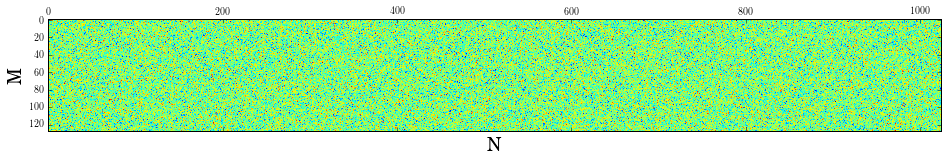

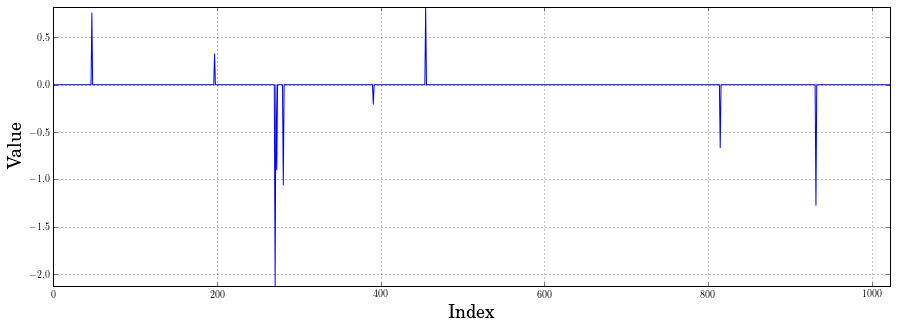

In [3]:
N = 1024      # Signal Dimensionality
M = 128       # Number of measurements
K = 10        # Number of non-zeros
x,xs = RandomKSparseSignal(K,N)
F = RandomOrthoProjection(M,N)

ShowProjection(F)
ShowSignal(x)

Now, given $F$ and the true $x$, lets calculate the value of the observations for this planted problem. We accomplish this through the simple matrix multiplication,
$$ y = F x$$

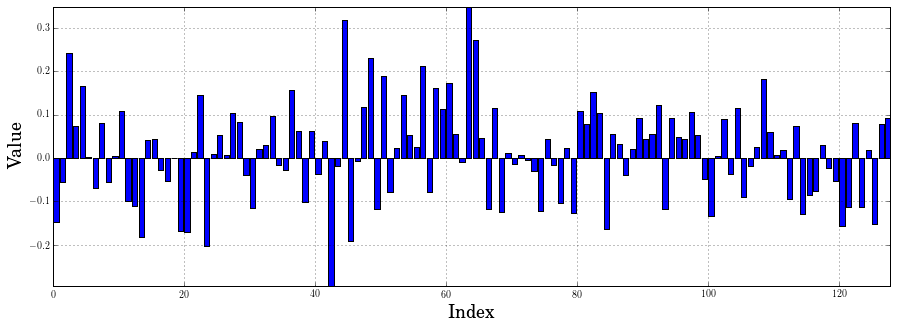

In [4]:
y = np.dot(F,x)
ShowMeasurements(y)

Our goal then is to find some reconstruction $\hat{x}$, which should be close to $x$, using only the observations $y$ and the projection matrix $F$. The first thing that one might attempt to do is to find the Least-Squares solution to this problem. As we saw in lecture, we cannot say that this solution will be anything at all like our original one, since there is an entire space of possible $\hat{x}$ which all map to the same $y$ in this case of under-sampling, $M<N$.

We can calculate the least-squares solution by using the Pseudo-Inverse of the matrix $F$,

$$\hat{x} = F^{\dagger} y = (F^T F)^{-1} F^T y$$.

This is also accomplished via the function `scipy.linalg.lstsq`.

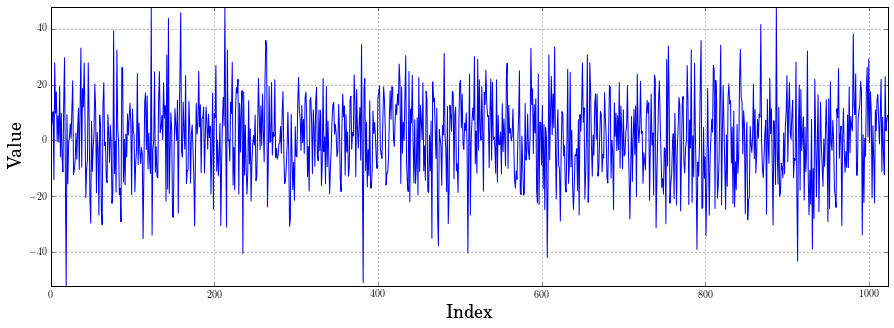

In [9]:
FtF = np.dot(F.T,F)   # Calculate $(F^T F)$
Fty = np.dot(F.T,y)   # Calculate $F^T y$
xlsq = la.solve(FtF,Fty)
ShowSignal(xlsq)
# ShowMeasurements(np.dot(F,xlsq))

# xlsq_ = la.lstsq(F,y)[0]
# ShowSignal(xlsq_)
# ShowMeasurements(np.dot(F,xlsq_))

# la.norm(xlsq_-xlsq)

We can see that this signal is nowhere near to the original one. However, as we mentioned in lecture, this signal does indeed match our observations, since it is one of the many vectors which lie in the space of possible solutions.

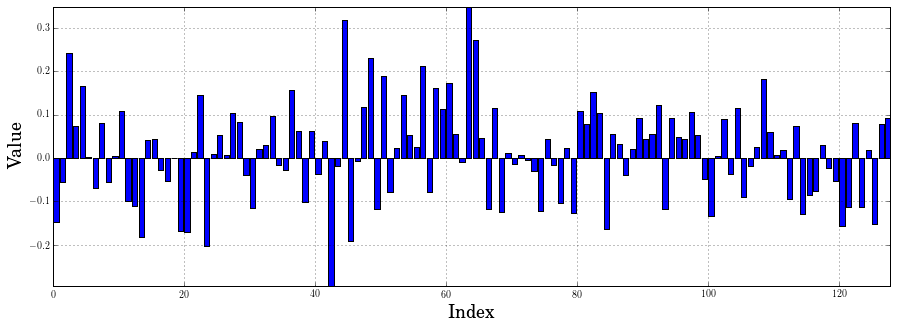

In [10]:
ShowMeasurements(np.dot(F,xlsq))

Now, as mentioned earlier, one the of the easiest approaches to regularization is *Ridge Regression* or *Tikhonov Regularization*. Here, we will regularize the least-squares problem by solving instead
$$\arg \min_{x}\quad||y - Fx||_2^2 + \lambda ||x||_2.$$

This problem can be solved directly via
$$\hat{x} = (F^T F + \lambda I)^{-1} F^T y.$$

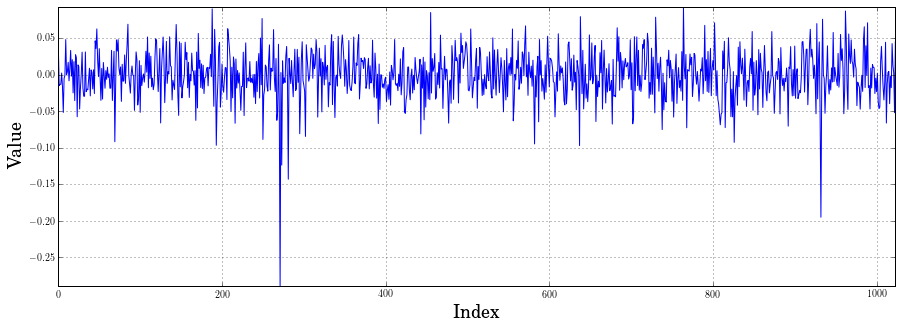

In [16]:
lam = 0.2
FtFI = FtF + lam * np.eye(np.shape(F)[1])

xtik = la.solve(FtFI,Fty)
ShowSignal(xtik)

So, we see that the $\ell_2$ regularized solution is more correlated with our original signal, however, it still suffers from a lot of noise on what should be the non-zero values. This is because the $\ell_2$ norm does not promote trunction to 0 for these small values.

## Orthogonal Matching Pursuit (OMP)
---

In [ ]:
def OrthogonalMatchingPursuit(F,y,K):
    m,n = np.shape(F)
    Support = np.empty((0,1),dtype=int)
    r = y
    A = []
    
    # Main Loop
    for t in range(1,K):
        # Find max correlated column over
        # all posibilities
        response = np.abs(np.dot(F.T,r))
        maxcorrcol = response.argmax()
        Support = np.append(Support,maxcorrcol)
        Support = np.unique(Support)
        NS = np.size(Support)

        # Construct the subset matrix
        A = F[:,Support.astype(int)]
        A = np.reshape(A,(m,NS))
        # Solve the LSQ problem
        if NS>1:
            xs = la.lstsq(A,y)[0]
            a = np.dot(A,xs)
        else:
            xs = lm.LinearRegression().fit(A,y).coef_[0]
            a = xs*A
            
        # Update residual
        r = np.reshape(r,(m,1))
        a = np.reshape(a,(m,1))
        r = y-a
        
    x = np.zeros((n,1))
    x[Support] = xs
    BoolSupport = np.zeros((n,1),dtype=bool)
    BoolSupport[Support] = True
    return x, BoolSupport

myxomp,Support = OrthogonalMatchingPursuit(F,y,K)
# ShowSignal(x)
# ShowSignal(myxomp)
ShowRecovery(x,myxomp)

## Iterative Hard Thresholding (IHT)
---

In [ ]:
def TopKThreshold(x,K):
    S = np.argsort(abs(x),axis=0)[::-1][:K]
    xT = np.zeros_like(x)
    xT[S] = x[S]
    
    return xT, S

def IterativeHardThresholding(F,y,K,iters):
    m,n = np.shape(F)
    x = np.zeros((n,1))
    for i in range(1,iters):
        r = y - np.dot(F,x)
        z = x + np.dot(F.T,r)
        x = TopKThreshold(z,K)[0]

    return x

xiht = IterativeHardThresholding(F,y,K,100)

# ShowSignal(x)
# ShowSignal(xiht)
ShowRecovery(x,xiht)
        

## Compressive Sampling Matching Pursuit (CoSaMP)
---

In [ ]:
def CompSampMatchingPursuit(F,y,K, iters):
    m,n = np.shape(F)
    a = np.zeros((n,1))
    v = y
    S = np.empty((0,1),dtype=int)
    
    for k in range(1,iters):
        # Form Signal PRoxy
        x = np.dot(F.T,v)     
        
        # Identify large components
        O = TopKThreshold(x,2*K)[1]
        
        # Merge Supports
        T = np.append(O,S)
        T = np.unique(T)

        # Solve reduced system
        b = np.zeros((n,1))
        b[T] = la.lstsq(F[:,T],y)[0]
        
        # Prune approximation
        a,S = TopKThreshold(b,K)
        
        # Update residual
        v = y - np.dot(F,a)        
    
    return a

xcosamp = CompSampMatchingPursuit(F,y,K,10)

# ShowSignal(x)
# ShowSignal(xcosamp)
ShowRecovery(x,xcosamp)

## L1 Minimization (LASSO)
---

In [ ]:
def L1Minimization(F,y,lam=1):
    return lm.Lasso(alpha=lam).fit(F,y).coef_

def ShowLassoPathMSE(F,y,x):
    NExp = 50
    Alphas = np.logspace(-8,0,NExp)
    out = lm.lasso_path(F,y,eps=0.01,alphas=Alphas)
#     Alphas = out[0]
    CoeffPath = out[1]
    
    MSEValues = np.zeros((NExp,1))
    for i in range(0,NExp):
        c = CoeffPath[:,:,i]
        MSEValues[i] = MSE(x,c)
    
    plt.plot(Alphas,MSEValues)
    plt.yscale("log")
    plt.xscale("log")

In [ ]:
xl1 = L1Minimization(F,y,0.0001)

ShowRecovery(x,xl1)

In [ ]:
#     out = lm.lasso_path(F,y,eps=0.001,n_alphas=20)
#     print(np.shape(out[1]))
ShowLassoPathMSE(F,y,x)

## Iterative Soft Thresholding
---

In [ ]:
def IterativeSoftThresholding(F,y,lam,iters):
    m,n = np.shape(F)
    x = np.zeros((n,1))
    for i in range(1,iters):
        r = y - np.dot(F,x)
        z = x + np.dot(F.T,r)
        x = pw.threshold(z,lam,mode='soft')
    return x

xist = IterativeSoftThresholding(F,y,0.001,100)

ShowRecovery(x,xist)

In [ ]:
?la.orth